In [1]:
import pandas
import starepandas
import geopandas
import matplotlib.pyplot as plt
import pystare
import numpy

# Cities

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.sids_from_xy(cities.Longitude, cities.Latitude, level=27)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_sids(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.add_trixels(inplace=True)

# Countries

In [3]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = countries.sort_values(by='name')
samerica = countries[countries.continent=='South America']

sids = starepandas.sids_from_gdf(samerica, level=7, force_ccw=True)
samerica = starepandas.STAREDataFrame(samerica, sids=sids)
trixels = samerica.make_trixels()
samerica.set_trixels(trixels, inplace=True)

<AxesSubplot:>

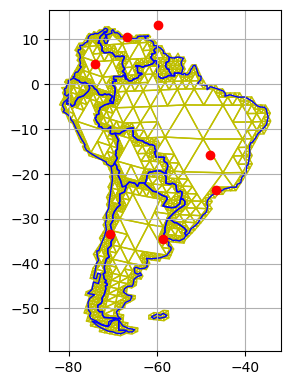

In [4]:
fig, ax = plt.subplots(figsize=(3,7), dpi=100)
ax.grid(True)

samerica.plot(ax=ax, trixels=True, color='y', lw=1, zorder=0)
samerica.plot(ax=ax, trixels=False, facecolor='none', edgecolor='blue', lw=1, zorder=1)
cities.plot(ax=ax, trixels=False, color='r', zorder=2)

<AxesSubplot:>

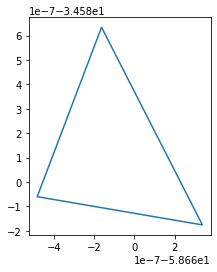

In [5]:
# The cities trixels are too small to be visible, 
# but they do exist:
cities[0:1].plot(trixels=True)

# Intersects Points

In [6]:
brasilia = cities[cities.City=='Brasilia']

In [7]:
# We do intersect of single feauture and collection; 
# Intersects of two collections only is defined row-wise

# Conventional intersect
intersects_conv = samerica.intersects(brasilia.iloc[0].geometry)

# Stare intersect
intersects_stare = samerica.stare_intersects(brasilia.iloc[0].sids)

In [8]:
sids = samerica[samerica['name']=='Brazil'].make_sids(level=5)
sids

29    [2749447572509687812, 2796735368597078020, 286...
Name: sids, dtype: object

In [9]:
cities

,City,Latitude,Longitude,sids,geometry,trixels
0,Buenos Aires,-34.58,-58.66,2663379193440875387,POINT (-58.66000 -34.58000),"POLYGON ((-58.66000 -34.58000, -58.66000 -34.5..."
1,Brasilia,-15.78,-47.91,2867415364672350651,POINT (-47.91000 -15.78000),"POLYGON ((-47.91000 -15.78000, -47.91000 -15.7..."
2,Santiago,-33.45,-70.66,2723774768829278555,POINT (-70.66000 -33.45000),"POLYGON ((-70.66000 -33.45000, -70.66000 -33.4..."
3,Bogota,4.60,-74.08,2667981979956219515,POINT (-74.08000 4.60000),"POLYGON ((-74.08000 4.60000, -74.08000 4.60000..."
4,Caracas,10.48,-66.86,2494081632617553403,POINT (-66.86000 10.48000),"POLYGON ((-66.86000 10.48000, -66.86000 10.480..."
5,Sao Paulo,-23.55,-46.63,2803225788975740475,POINT (-46.63000 -23.55000),"POLYGON ((-46.63000 -23.55000, -46.63000 -23.5..."
6,Bridgetown,13.10,-59.62,2518254660685127707,POINT (-59.62000 13.10000),"POLYGON ((-59.62000 13.10000, -59.62000 13.100..."


In [10]:
sum(~cities.stare_intersects(sids.iloc[0]))

5

# Intersects Polygons

In [11]:
# Sao Paulo Sate
fname = 'zip://../tests/data/sp_state.zip'
sao_paulo = geopandas.read_file(fname) # Nice flex
sao_paulo = sao_paulo[sao_paulo.mslink==221]
sids = starepandas.sids_from_gdf(sao_paulo, level=10, force_ccw=True)
sao_paulo = starepandas.STAREDataFrame(sao_paulo, sids=sids)

In [12]:
sum(~samerica.stare_intersects(sao_paulo['sids'].iloc[0]))

12